# Algoritmo de Lenvenberg Marquardt

### Función de prueba

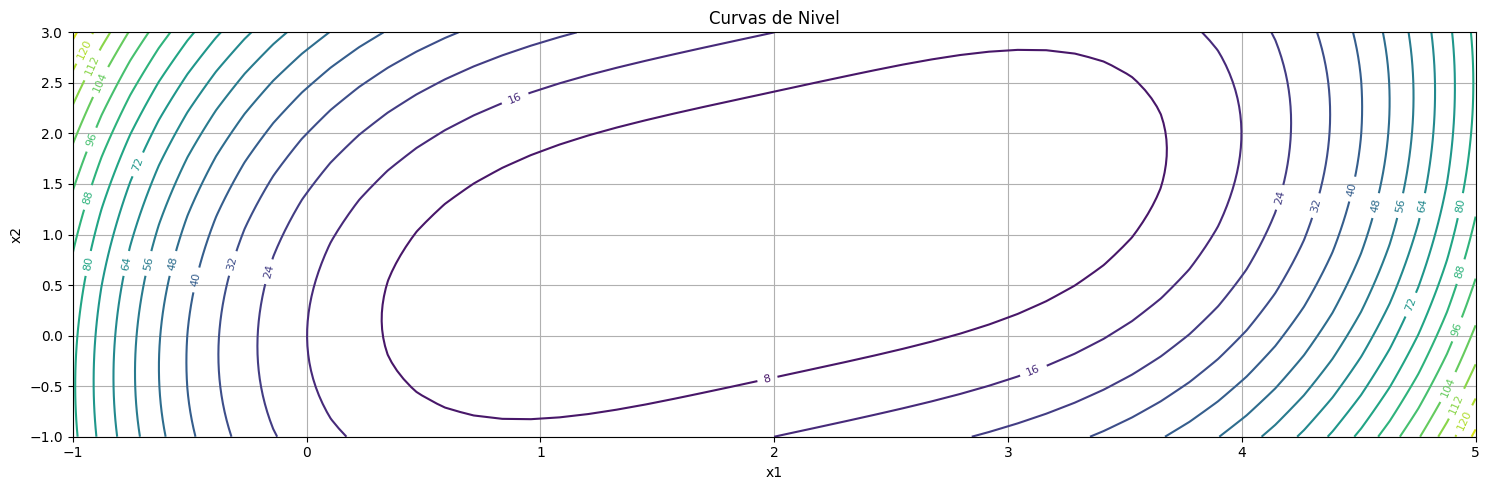

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def quasiconvex_function(x):
  """
  Función de dos variables: f(x1, x2) = (x1 - 2)^4 + (x1 - 2*x2)^2
  Para graficar, usaremos x1 = x y x2 = 0 como caso particular
  """
  if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 2:
    x1, x2 = x
    return (x1 - 2)**4 + (x1 - 2*x2)**2
  else:
    # Para compatibilidad con el código existente, asumimos x2 = 0
    x1 = x
    x2 = 0
    return (x1 - 2)**4 + (x1 - 2*x2)**2

# Crear gráfica 3D de la función de dos variables
fig = plt.figure(figsize=(15, 5))

# Subplot 2: Curvas de nivel
ax2 = fig.add_subplot(111)
x1_range = np.linspace(-1, 5, 50)
x2_range = np.linspace(-1, 3, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = (X1 - 2)**4 + (X1 - 2*X2)**2

contour = ax2.contour(X1, X2, Z, levels=20)
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Curvas de Nivel')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [6]:
def gradient(x, h=1e-8):
    """Calcula el gradiente usando diferencias finitas centrales"""
    x1, x2 = x
    
    # Diferencia finita para x1
    df_dx1 = (quasiconvex_function([x1 + h, x2]) - quasiconvex_function([x1 - h, x2])) / (2 * h)
    
    # Diferencia finita para x2
    df_dx2 = (quasiconvex_function([x1, x2 + h]) - quasiconvex_function([x1, x2 - h])) / (2 * h)
    
    return np.array([df_dx1, df_dx2])

def hessian(x, h=1e-5):
    """Calcula la matriz Hessiana usando diferencias finitas"""
    x1, x2 = x
    
    # Segundas derivadas parciales
    # d2f/dx1^2
    d2f_dx1_dx1 = (quasiconvex_function([x1 + h, x2]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1 - h, x2])) / (h**2)
    
    # d2f/dx2^2
    d2f_dx2_dx2 = (quasiconvex_function([x1, x2 + h]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1, x2 - h])) / (h**2)
    
    # d2f/dx1dx2 (derivada mixta)
    d2f_dx1_dx2 = (quasiconvex_function([x1 + h, x2 + h]) - quasiconvex_function([x1 + h, x2 - h]) - 
                    quasiconvex_function([x1 - h, x2 + h]) + quasiconvex_function([x1 - h, x2 - h])) / (4 * h**2)
    
    return np.array([[d2f_dx1_dx1, d2f_dx1_dx2],
                    [d2f_dx1_dx2, d2f_dx2_dx2]])

def is_positive_definite(matrix):
    """Verifica si una matriz es definida positiva usando Cholesky"""
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

### Desarrollo del algoritmo

In [7]:
def levenberg_marquardt(x_initial, epsilon_initial=0.25, tolerance=1e-6, max_iterations=100):
    """
    Parámetros:
    - x_initial: punto inicial [x1, x2]
    - epsilon_initial: parámetro de amortiguamiento inicial
    - tolerance: tolerancia para el criterio de parada
    - max_iterations: número máximo de iteraciones
    """
    
    # Inicialización
    x_k = np.array(x_initial)
    epsilon_k = epsilon_initial
    k = 1
    
    # CODE - Almacenar historial para visualización
    history = {'x': [x_k.copy()], 'f': [quasiconvex_function(x_k)], 'epsilon': [epsilon_k]}
    
    print(f"Iteración 0: x = {x_k}, f(x) = {quasiconvex_function(x_k):.6f}, ε = {epsilon_k}")
    
    for iteration in range(max_iterations):
        # Paso 2.1: Cálculo de la dirección de búsqueda
        grad_k = gradient(x_k)
        H_k = hessian(x_k)
        
        # Verificar criterio de parada por gradiente
        if np.linalg.norm(grad_k) < tolerance:
            print(f"Convergencia alcanzada: ||∇f|| = {np.linalg.norm(grad_k):.8f} < {tolerance}")
            break
        
        # Asegurar que B sea definida positiva
        while True:
            B = H_k + epsilon_k * np.eye(2)
            if is_positive_definite(B):
                break
            epsilon_k *= 4
            print(f"  Aumentando ε a {epsilon_k} para asegurar matriz definida positiva")
        
        # Resolver sistema lineal B * d_k = -∇f(x_k)
        d_k = np.linalg.solve(B, -grad_k)
        
        # Paso 2.2: Evaluación y aceptación del paso
        f_current = quasiconvex_function(x_k)
        f_new = quasiconvex_function(x_k + d_k)
        
        actual_reduction = f_current - f_new
        
        # Reducción predicha por aproximación cuadrática
        predicted_reduction = -np.dot(grad_k, d_k) - 0.5 * np.dot(d_k, np.dot(H_k, d_k))
        
        # Razón de confiabilidad
        if abs(predicted_reduction) < 1e-12:
            R_k = 0
        else:
            R_k = actual_reduction / predicted_reduction
        
        print(f"Iteración {k}: R_k = {R_k:.4f}, reducción real = {actual_reduction:.6f}, predicha = {predicted_reduction:.6f}")
        
        # Decidir actualización según R_k
        if R_k > 0.75:
            # Mejora confiable
            x_k = x_k + d_k
            epsilon_k = epsilon_k / 2
            print(f"  Paso aceptado (R_k > 0.75), nuevo x = {x_k}, ε reducido a {epsilon_k}")
        elif R_k >= 0.25:
            # Mejora moderada
            x_k = x_k + d_k
            # epsilon_k se mantiene igual
            print(f"  Paso aceptado (0.25 ≤ R_k ≤ 0.75), nuevo x = {x_k}, ε = {epsilon_k}")
        else:
            # Poca mejora o empeoramiento
            epsilon_k = 4 * epsilon_k
            print(f"  Paso rechazado (R_k < 0.25), x = {x_k}, ε aumentado a {epsilon_k}")
        
        # Guardar historial
        history['x'].append(x_k.copy())
        history['f'].append(quasiconvex_function(x_k))
        history['epsilon'].append(epsilon_k)
        
        k += 1
    
    print(f"\nSolución final: x = {x_k}")
    print(f"Valor de la función: f(x) = {quasiconvex_function(x_k):.8f}")
    print(f"Norma del gradiente: ||∇f|| = {np.linalg.norm(gradient(x_k)):.8f}")
    print(f"Número de iteraciones: {k-1}")
    
    return x_k, history

Iteración 0: x = [0 3], f(x) = 52.000000, ε = 0.25
Iteración 1: R_k = 1.0472, reducción real = 48.844026, predicha = 46.640566
  Paso aceptado (R_k > 0.75), nuevo x = [0.66990509 0.41568955], ε reducido a 0.125
Iteración 2: R_k = 1.1973, reducción real = 2.529302, predicha = 2.112559
  Paso aceptado (R_k > 0.75), nuevo x = [1.11027259 0.55299097], ε reducido a 0.0625
Iteración 3: R_k = 1.1989, reducción real = 0.500849, predicha = 0.417755
  Paso aceptado (R_k > 0.75), nuevo x = [1.404426   0.70105624], ε reducido a 0.03125
Iteración 4: R_k = 1.1984, reducción real = 0.100514, predicha = 0.083876
  Paso aceptado (R_k > 0.75), nuevo x = [1.60114253 0.80018405], ε reducido a 0.015625
Iteración 5: R_k = 1.1978, reducción real = 0.020208, predicha = 0.016871
  Paso aceptado (R_k > 0.75), nuevo x = [1.73274753 0.86624474], ε reducido a 0.0078125
Iteración 6: R_k = 1.1971, reducción real = 0.004071, predicha = 0.003401
  Paso aceptado (R_k > 0.75), nuevo x = [1.82082771 0.91037076], ε reduci

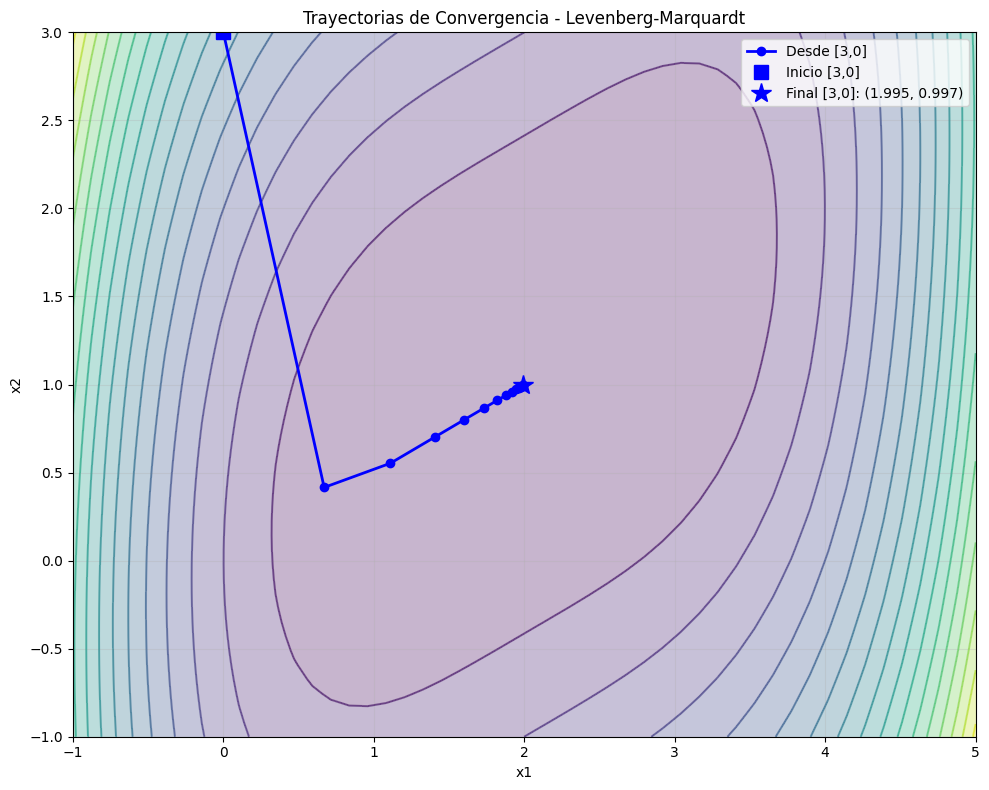


=== RESUMEN DE RESULTADOS ===
Punto Inicial   Solución Final       f(x) Final      Iteraciones 
----------------------------------------------------------------------
[3, 0]          [1.994919, 0.997460]    6.66e-10        15


In [8]:
# Ejecutar con punto inical
solution, history = levenberg_marquardt([0, 3])

# Visualizar solo las trayectorias de convergencia
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Gráfico: Trayectorias sobre las curvas de nivel
ax.contour(X1, X2, Z, levels=20, alpha=0.6)
ax.contourf(X1, X2, Z, levels=20, alpha=0.3, cmap='viridis')

# Trayectoria desde [3, 0]
x_traj2 = [point[0] for point in history['x']]
y_traj2 = [point[1] for point in history['x']]
ax.plot(x_traj2, y_traj2, 'bo-', linewidth=2, markersize=6, label='Desde [3,0]')
ax.plot(x_traj2[0], y_traj2[0], 'bs', markersize=10, label='Inicio [3,0]')
ax.plot(x_traj2[-1], y_traj2[-1], 'b*', markersize=15, label=f'Final [3,0]: ({solution[0]:.3f}, {solution[1]:.3f})')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Trayectorias de Convergencia - Levenberg-Marquardt')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla comparativa de resultados
print("\n=== RESUMEN DE RESULTADOS ===")
print(f"{'Punto Inicial':<15} {'Solución Final':<20} {'f(x) Final':<15} {'Iteraciones':<12}")
print("-" * 70)
print(f"[3, 0]          [{solution[0]:.6f}, {solution[1]:.6f}]    {history['f'][-1]:.2e}        {len(history['f'])-1}")
